In [ ]:
# Install RDKit
!pip install rdkit

In [ ]:
# Import Libraries
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import random

print(f"RDKit version: {rdkit.__version__}")

RDKit version: 2024.09.5


In [ ]:
#Load and Prepare Data
# Load dataset
url = 'https://raw.githubusercontent.com/dataprofessor/data/master/delaney.csv'
sol_df = pd.read_csv(url)

# Display first few rows of the dataset
print("Dataset head:")
display(sol_df.head())

# Convert SMILES to RDKit molecules
mol_data = [Chem.MolFromSmiles(element) for element in sol_df.SMILES]
print(f"\nTotal molecules processed: {len(mol_data)}")
print(f"First molecule: {mol_data[0]}")

Dataset head:


,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl



Total molecules processed: 1144
First molecule: <rdkit.Chem.rdchem.Mol object at 0x7d296deb5b60>


In [ ]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import Chem

def draw_molecules_grid(smiles_dict, n_cols=3, img_size=(300, 300)):
    """Draw molecules in a grid layout with labels"""
    mols = []
    legends = []

    # Convert SMILES to RDKit molecules
    for name, smiles in smiles_dict.items():
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Generate 2D coordinates for the molecule
            AllChem.Compute2DCoords(mol)
            mols.append(mol)
            legends.append(name)

    # Calculate number of rows needed
    n_rows = (len(mols) + n_cols - 1) // n_cols

    # Create the grid image
    img = Draw.MolsToGridImage(mols,
                              molsPerRow=n_cols,
                              subImgSize=img_size,
                              legends=legends,
                              returnPNG=False)

    # Display using matplotlib
    plt.figure(figsize=(15, 5*n_rows))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

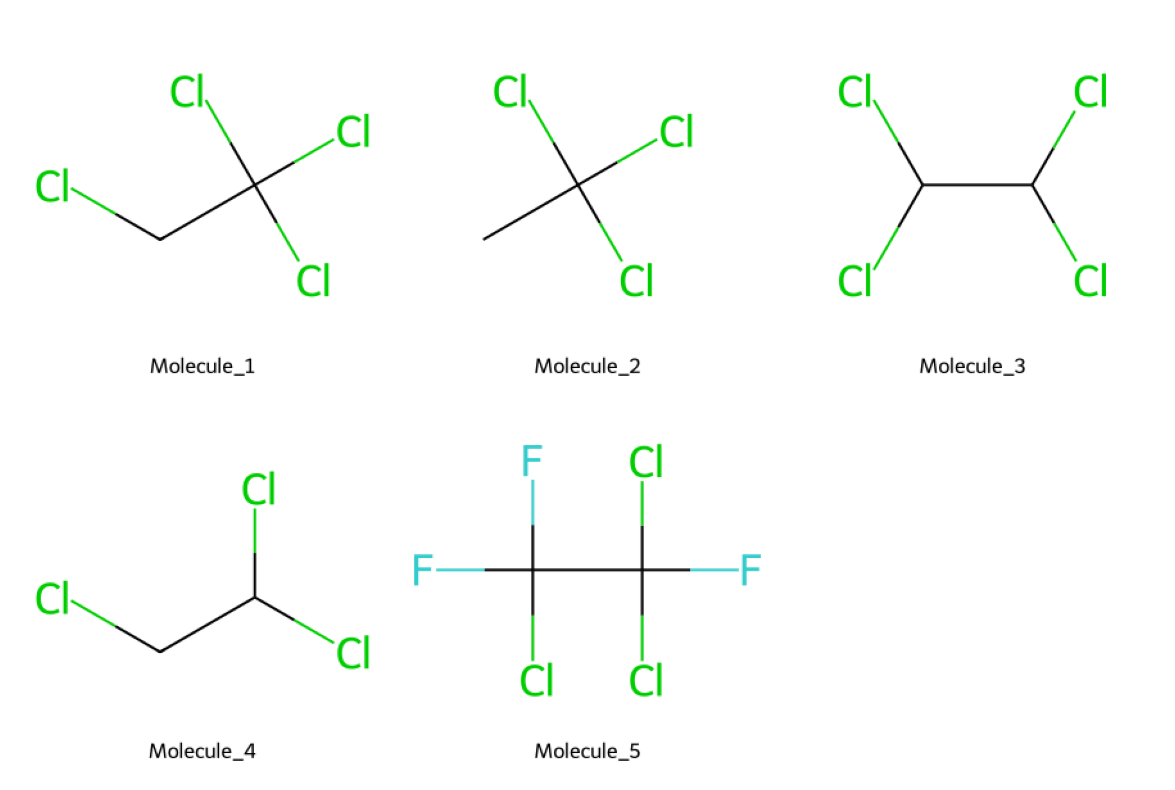

In [ ]:
sample_molecules = dict(zip(
    [f'Molecule_{i+1}' for i in range(5)],  # Names
    sol_df['SMILES'].head(5)  # SMILES strings
))

# Visualize these molecules
draw_molecules_grid(sample_molecules)

In [ ]:
#Calculate Molecular Descriptors
mol_descriptors_np = np.arange(1,1)

for mol in mol_data:
    clogP = Descriptors.MolLogP(mol)
    mol_weight = Descriptors.MolWt(mol)
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)

    row = np.array([clogP, mol_weight, num_rotatable_bonds])

    if mol_descriptors_np.size == 0:
        mol_descriptors_np = row
    else:
        mol_descriptors_np = np.vstack([mol_descriptors_np, row])

print("Molecular descriptors shape:", mol_descriptors_np.shape)

Molecular descriptors shape: (1144, 3)


In [ ]:
#Calculate Aromatic Proportion
aromatic_arr = []

for mol in mol_data:
    total_atoms = mol.GetNumAtoms()
    aromatic_count = 0
    for i in range(total_atoms):
        if mol.GetAtomWithIdx(i).GetIsAromatic():
            aromatic_count += 1

    aromatic_arr.append(aromatic_count/Descriptors.HeavyAtomCount(mol))

aromatic_np = np.array(aromatic_arr).reshape(-1,1)
print("Aromatic proportions shape:", aromatic_np.shape)

Aromatic proportions shape: (1144, 1)


In [ ]:
#Create Final Dataset
# Combine all descriptors
all_descriptors_np = np.hstack([mol_descriptors_np, aromatic_np])

# Create descriptors dataframe
descriptors_df = pd.DataFrame(all_descriptors_np,
                            columns=['cLogP', 'MolWeight', 'numRotatableBonds', 'AromaticProportion'])

# Add solubility values
descriptors_df = pd.concat([descriptors_df, sol_df["measured log(solubility:mol/L)"]], axis=1)
descriptors_df.rename(columns={'measured log(solubility:mol/L)': 'log(solubility:mol/L)'}, inplace=True)

# Display dataset info
print("Final dataset info:")
display(descriptors_df.describe())

Final dataset info:


,cLogP,MolWeight,numRotatableBonds,AromaticProportion,log(solubility:mol/L)
count,1144.000000,1144.000000,1144.000000,1144.000000,1144.000000
mean,2.449133,204.631675,2.173951,0.364932,-3.057997
std,1.866003,102.620500,2.627398,0.343305,2.096502
min,-7.571400,16.043000,0.000000,0.000000,-11.600000
25%,1.414900,122.126000,0.000000,0.000000,-4.332250
50%,2.340300,183.594500,1.000000,0.375000,-2.870500
75%,3.406475,270.715750,3.000000,0.666667,-1.600000
max,10.388600,780.949000,23.000000,1.000000,1.580000


In [ ]:
#Data Preparation for Modeling
# Set seed for reproducibility
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# Prepare features and target
X = descriptors_df[['cLogP', 'MolWeight', 'numRotatableBonds', 'AromaticProportion']].values
Y = descriptors_df[['log(solubility:mol/L)']].values

# Normalize data
scaler = MinMaxScaler()
normalized_X = scaler.fit_transform(X)
normalized_Y = scaler.fit_transform(Y).ravel()

# Split data
X_train, X_test, Y_train, Y_test = train_test_split(normalized_X, normalized_Y,
                                                    test_size=0.2, random_state=SEED)

print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"Y_test: {Y_test.shape}")

Data shapes:
X_train: (915, 4)
X_test: (229, 4)
Y_train: (915,)
Y_test: (229,)


Linear regression - MSE: 0.0053
Linear regression - R²: 0.8070


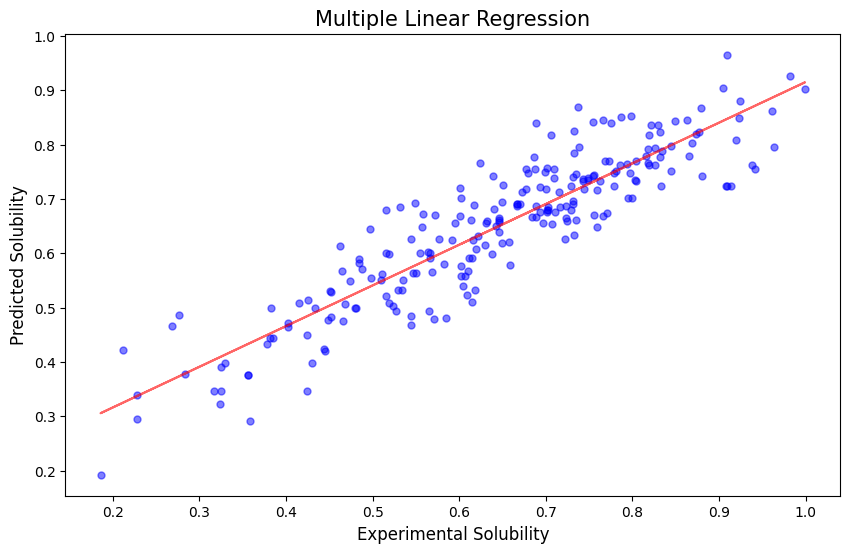

In [ ]:
#Linear Regression Model
# Train and evaluate linear regression model
lr_model = linear_model.LinearRegression()
lr_model.fit(X_train, Y_train)

Y_pred_test_lr = lr_model.predict(X_test)
lin_reg_mse = mean_squared_error(Y_test, Y_pred_test_lr)
lin_reg_r2 = r2_score(Y_test, Y_pred_test_lr)

print(f'Linear regression - MSE: {lin_reg_mse:.4f}')
print(f'Linear regression - R²: {lin_reg_r2:.4f}')

# Plot results
plt.figure(figsize=(10, 6))
slope_lin, intercept_lin = np.polyfit(Y_test, Y_pred_test_lr, 1)
plt.scatter(x=Y_test, y=Y_pred_test_lr, color='blue', s=25, alpha=0.5)
plt.plot(Y_test, slope_lin*Y_test + intercept_lin, color='red', alpha=0.6)
plt.xlabel('Experimental Solubility', fontsize=12)
plt.ylabel('Predicted Solubility', fontsize=12)
plt.title('Multiple Linear Regression', fontsize=15)
plt.show()

Feature Importances:


,importance
cLogP,0.826899
MolWeight,0.127917
numRotatableBonds,0.020095
AromaticProportion,0.025088



Random forest regression - MSE: 0.0023
Random forest regression - R²: 0.9159


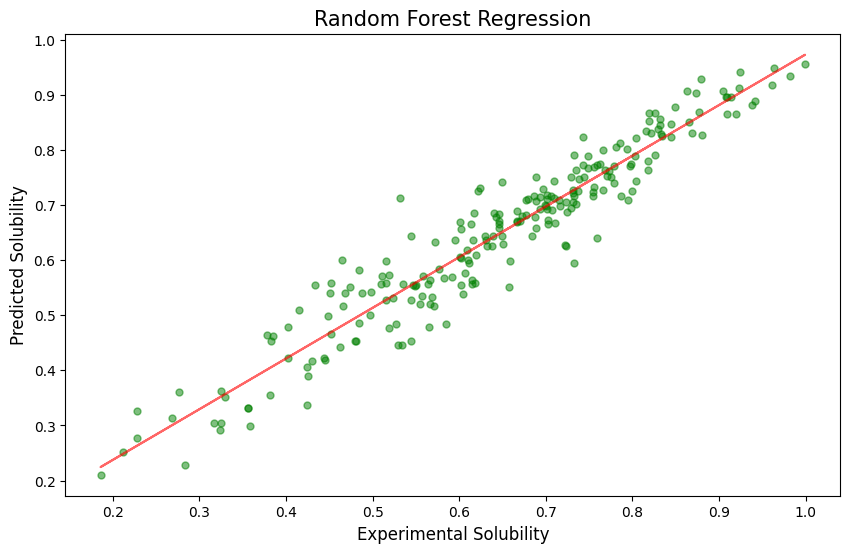

In [ ]:
#Random Forest Model
# Train and evaluate random forest model
rf_reg = RandomForestRegressor(random_state=SEED)
rf_reg.fit(X_train, Y_train)

Y_pred_rf_reg = rf_reg.predict(X_test)
rf_reg_mse = mean_squared_error(Y_test, Y_pred_rf_reg)
rf_reg_r2 = r2_score(Y_test, Y_pred_rf_reg)

# Display feature importances
feature_importance = pd.DataFrame(
    {'importance': rf_reg.feature_importances_},
    index=descriptors_df.iloc[:,:-1].columns
)
print("Feature Importances:")
display(feature_importance)

print(f'\nRandom forest regression - MSE: {rf_reg_mse:.4f}')
print(f'Random forest regression - R²: {rf_reg_r2:.4f}')

# Plot results
plt.figure(figsize=(10, 6))
slope_rf, intercept_rf = np.polyfit(Y_test, Y_pred_rf_reg, 1)
plt.scatter(x=Y_test, y=Y_pred_rf_reg, color='green', s=25, alpha=0.5)
plt.plot(Y_test, slope_rf*Y_test + intercept_rf, color='red', alpha=0.6)
plt.xlabel('Experimental Solubility', fontsize=12)
plt.ylabel('Predicted Solubility', fontsize=12)
plt.title('Random Forest Regression', fontsize=15)
plt.show()


Model Comparison Summary:


,Metric,Linear Regression,Random Forest
0,MSE,0.005345,0.002327
1,RMSE,0.073108,0.048243


<Figure size 1000x600 with 0 Axes>

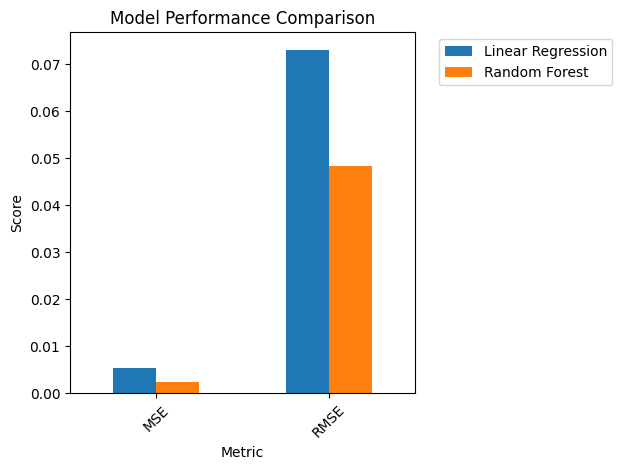

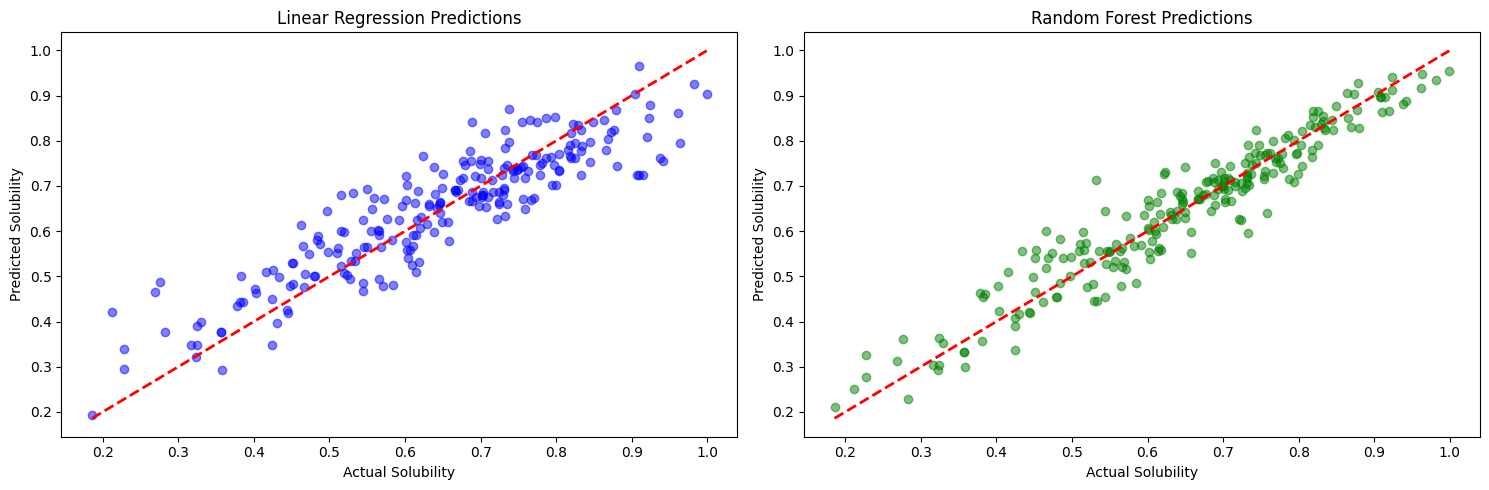

In [ ]:
# Model Comparison Summary
comparison_summary = pd.DataFrame({
    'Metric': ['MSE', 'RMSE'],
    'Linear Regression': [
        lin_reg_mse,  # MSE
        np.sqrt(lin_reg_mse),  # RMSE
    ],
    'Random Forest': [
        rf_reg_mse,  # MSE
        np.sqrt(rf_reg_mse),  # RMSE
    ]
})

print("\nModel Comparison Summary:")
display(comparison_summary)

# Visualize comparison
plt.figure(figsize=(10, 6))
comparison_summary.set_index('Metric').plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot predictions side by side
plt.figure(figsize=(15, 5))

# Linear Regression subplot
plt.subplot(1, 2, 1)
plt.scatter(Y_test, Y_pred_test_lr, color='blue', alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Linear Regression Predictions')

# Random Forest subplot
plt.subplot(1, 2, 2)
plt.scatter(Y_test, Y_pred_rf_reg, color='green', alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Solubility')
plt.ylabel('Predicted Solubility')
plt.title('Random Forest Predictions')

plt.tight_layout()
plt.show()


Reference: ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure (https://pubs.acs.org/doi/10.1021/ci034243x)


In [ ]:
# Create molecule from SMILES
mefenamic_smiles = "CC1=CC=C(C=C1)NC2=CC=CC=C2C(=O)O"  # SMILES for mefenamic acid
mol = Chem.MolFromSmiles(mefenamic_smiles)

# Calculate the same descriptors used in training
clogP = Descriptors.MolLogP(mol)
mol_weight = Descriptors.MolWt(mol)
num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)

# Calculate aromatic proportion
total_atoms = mol.GetNumAtoms()
aromatic_count = 0
for i in range(total_atoms):
    if mol.GetAtomWithIdx(i).GetIsAromatic():
        aromatic_count += 1
aromatic_prop = aromatic_count/Descriptors.HeavyAtomCount(mol)

# Combine all features into array
features = np.array([clogP, mol_weight, num_rotatable_bonds, aromatic_prop]).reshape(1, -1)

# Make prediction using trained model
predicted_solubility = rf_reg.predict(features)

print(f"Predicted log solubility of mefenamic acid in water: {predicted_solubility[0]:.3f}")